<a href="https://colab.research.google.com/github/jasontancc/Can-ML-predict-stock-prices-/blob/main/Can_ML_predict_stock_prices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Can ML predict stock prices better than technical analysis eg MACD?


In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
# import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, confusion_matrix


Here we will get the stock data from yFinance and perform all the basic calcuations such as moving averages, RSI, MACD and Signal Line.

The MACD is the difference between the 12-day and 26-day exponential moving averages (EMA)
The Signal Line is a 9-day EMA of the MACD

[*********************100%***********************]  1 of 1 completed


              precision    recall  f1-score   support

          -1       0.44      0.48      0.46       313
           1       0.58      0.54      0.56       409

    accuracy                           0.51       722
   macro avg       0.51      0.51      0.51       722
weighted avg       0.52      0.51      0.52       722



<ipython-input-2-ab846ac65cc7>:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_data['Predicted_Signal'] = np.nan


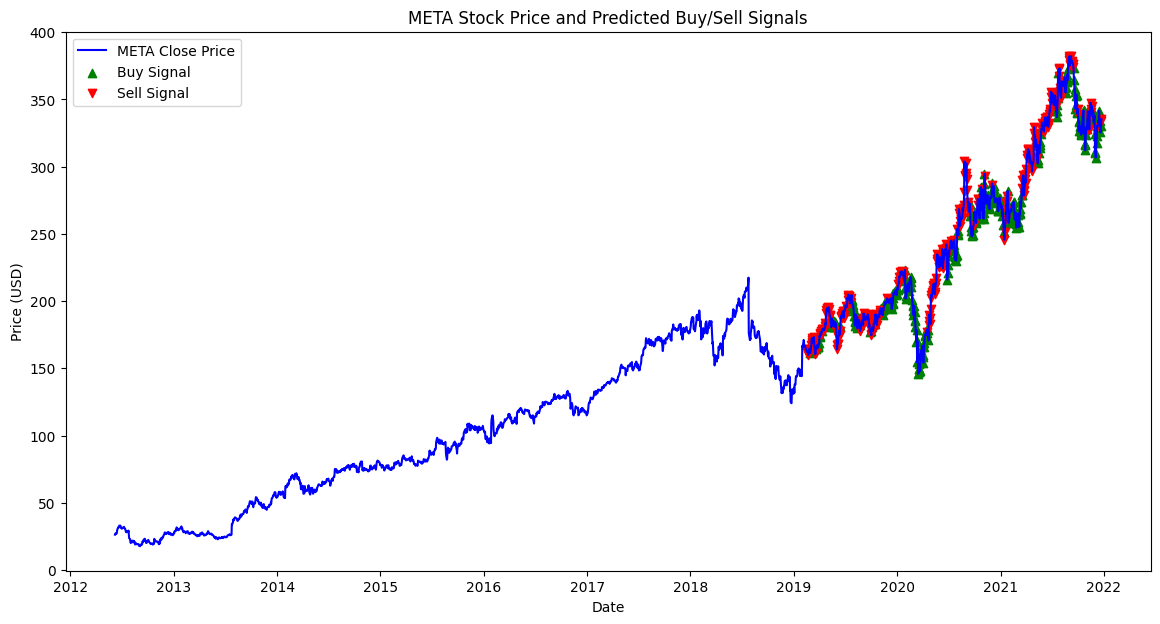

In [2]:
# Define global variables
ticker ='META'
start_date = '2012-01-01'
end_date = '2022-01-01'
future_days = 5
my_test_size = 0.3

# Download stock data from yFinance
ticker_data = yf.download(ticker, start=start_date, end=end_date)

# Calculate additional features (Moving averages, RSI, MACD)
ticker_data['5_day_MA'] = ticker_data['Close'].rolling(window=5).mean()
ticker_data['10_day_MA'] = ticker_data['Close'].rolling(window=10).mean()

# Relative Strength Index (RSI) calculation
delta = ticker_data['Close'].diff(1)
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()
rs = avg_gain / avg_loss
ticker_data['RSI'] = 100 - (100 / (1 + rs))

# MACD and Signal Line calculation

short_ema = ticker_data['Close'].ewm(span=12, adjust=False).mean()
long_ema = ticker_data['Close'].ewm(span=26, adjust=False).mean()
macd = short_ema - long_ema
signal = macd.ewm(span=9, adjust=False).mean()
ticker_data['MACD'] = macd
ticker_data['Signal Line'] = signal

# Set Future_Close to be 5 days after current date
# future_days = 5  # parameters moved to top section
ticker_data['Future_Close'] = ticker_data['Close'].shift(-future_days)
# Target label : 1 if price increases in the next N days, -1 if decreases
ticker_data['Target'] = np.where(ticker_data['Future_Close'] > ticker_data['Close'], 1, -1)

# Drop rows with missing values
ticker_data = ticker_data.dropna()

# below suppose to remove warning but MACD confusion matrix becomes all zero (due to use of iloc() in MACD loop) - doesn't work
# pd.options.mode.copy_on_write = True  # to avoid warning errors -



To predict the best date to buy or sell stock to maximize returns, we implement a simple machine learning model using historical stock data.

One approach is to train a classification model that labels each day as a "buy" or "sell" signal, based on whether the price increases or decreases in the future.

We can use features like:

- Technical indicators (e.g., moving averages, RSI, MACD)
- Historical price data (e.g., previous day prices, volumes)

Here's a simple approach using a Random Forest classifier:

Features:
- Moving Averages (e.g., 5-day, 10-day)
- MACD and Signal Line
- Relative Strength Index (RSI)

Target:
- A label that indicates whether the price will increase or decrease in the next N days (1 for "buy", -1 for "sell").

Buy/Sell Signals:

- The green ^ markers indicate predicted buy signals, and the red v markers indicate predicted sell signals.

Evaluation:
- The classification_report provides metrics such as accuracy, precision, and recall to evaluate the model's performance on predicting buy/sell signals.


In [ ]:
# Define features and target
features = ['5_day_MA', '10_day_MA', 'RSI', 'MACD', 'Signal Line']
X = ticker_data[features]
y = ticker_data['Target']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=my_test_size, shuffle=False)

# Initialize and train the Random Forest classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions for Random Forest
y_pred_rf = rf_model.predict(X_test)


#### print initial training data and buy/sell signal using ML

# Classification report to evaluate performance
print(classification_report(y_test, y_pred_rf))

# Predict buy/sell signals on the test data
ticker_data['Predicted_Signal'] = np.nan
ticker_data.iloc[-len(y_test):, ticker_data.columns.get_loc('Predicted_Signal')] = y_pred_rf

# Plot original price and predicted buy/sell signals
plt.figure(figsize=(14,7))
plt.plot(ticker_data.index, ticker_data['Close'], label=ticker+' Close Price', color='blue')

# Mark buy/sell signals
buy_signals = ticker_data[ticker_data['Predicted_Signal'] == 1]
sell_signals = ticker_data[ticker_data['Predicted_Signal'] == -1]

plt.scatter(buy_signals.index, buy_signals['Close'], marker='^', color='green', label='Buy Signal', alpha=1)
plt.scatter(sell_signals.index, sell_signals['Close'], marker='v', color='red', label='Sell Signal', alpha=1)

plt.title(ticker+' Stock Price and Predicted Buy/Sell Signals')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()



Simulating Buy and Sell:

- The algorithm "buys" when a Predicted_Signal is 1 and "sells" when the signal is -1.
- We keep track of whether we are holding a position (i.e., have bought the stock), and calculate the profit based on the difference between the buy and sell prices.
- The profit is calculated as profit += (sell_price - buy_price) / buy_price * balance.

Cumulative Returns:

- The balance is updated with the profits after each transaction, and this is stored in a list called cumulative_returns.
- This list is plotted at the end to visualize how the portfolio value changes over time.

Initial Balance:

- The simulation starts with an initial balance of $10,000 (initial_balance = 10000).

Result:
- We will plot the cumulative returns of the strategy over time, and the final portfolio value will be displayed to show how much the strategy has earned compared to the initial balance.

Buy-and-Hold Strategy:
- Buy on the first day.
- Hold the stock throughout the entire period.
- Sell on the last day.

MACD Strategy:
- For every day, check if the MACD has crossed the Signal Line, and take actions accordingly (buy/sell).
- Track the cumulative returns in cumulative_returns_macd.

Machine Learning Strategy Accuracy:
- Compare the model's predicted signals (y_pred) with the actual y_test (the real future movement of stock prices).
- Use the accuracy_score from sklearn.metrics to calculate accuracy.

MACD Strategy Accuracy:
- Define whether each trade (buy/sell) was profitable or not by comparing the buy price with the following sell price.
- Track how many of these trades were profitable and calculate the accuracy based on the percentage of profitable trades.

Buy-and-Hold Strategy Accuracy:
- Since the buy-and-hold strategy only makes one trade (buy at the start, sell at the end), we can evaluate its accuracy by calculating whether the stock's price increased or decreased over the full period.


<ipython-input-3-d488aed948e1>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_data['MACD_Signal'] = np.nan   # for MACD confusion matrix calculation, we need to calculate buy/sell signals based on MACD Signal
<ipython-input-3-d488aed948e1>:53: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_in

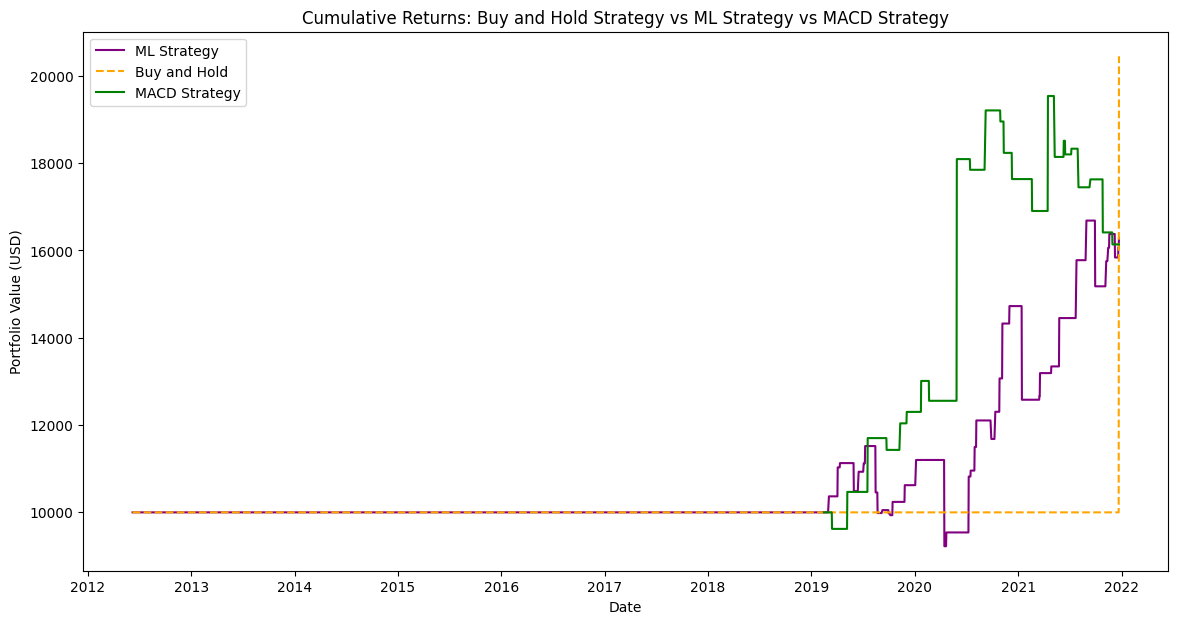

Initial Portfolio value : $10000
------------------------------------------------------------------------------
                       Buy and Hold      ML Strategy       MACD Strategy
------------------------------------------------------------------------------
Final Portfolio :       $20448             $16285              $16137
Accuracy % :            100%                  51%                 46%
CONFUSION MATRIX:
True Positive :             NA                219               15
False Positive :            NA                164               10
True Negative :             NA                149               14
False Negative :            NA                185               10
----------------------------------------------------------------------


In [3]:

# Simulate the trading strategy based on predicted signals (ML Strategy)
initial_balance = 10000  # Starting with $10,000
position = 0  # Whether we have a position in the stock (1 for holding, 0 for not holding)
balance = initial_balance
profit = 0
buy_price = 0  # The price at which the stock was bought
cumulative_returns_ml = []  # Cumulative balance for machine learning strategy

# ticker_data = ticker_data.copy()  # working with a fresh copy to avoid warning errors - doesn't remove warning errors??

for i in range(len(ticker_data)):
    if ticker_data['Predicted_Signal'].iloc[i] == 1 and position == 0:
        # Buy signal
        position = 1
        buy_price = ticker_data['Close'].iloc[i]
    elif ticker_data['Predicted_Signal'].iloc[i] == -1 and position == 1:
        # Sell signal
        sell_price = ticker_data['Close'].iloc[i]
        position = 0
        profit += (sell_price - buy_price) / buy_price * balance  # Calculate profit
        balance = initial_balance + profit  # Update balance
    cumulative_returns_ml.append(balance)

# Buy-and-hold strategy (Buy on first day and sell on last day)
initial_balance_bh = 10000  # Starting with $10,000
buy_price_bh = ticker_data['Close'].iloc[-len(y_test)]  # Buy on the first day of the test set
sell_price_bh = ticker_data['Close'].iloc[-1]  # Sell on the last day of the test set
profit_bh = (sell_price_bh - buy_price_bh) / buy_price_bh * initial_balance_bh
final_balance_bh = initial_balance_bh + profit_bh

# MACD Strategy
initial_balance_macd = 10000  # Starting with $10,000
balance_macd = initial_balance_macd
position_macd = 0  # Whether we have a position in the stock (1 for holding, 0 for not holding)
profit_macd = 0
buy_price_macd = 0  # The price at which the stock was bought
cumulative_returns_macd = []  # Cumulative balance for MACD strategy

# MACD Strategy Accuracy calcuation
profitable_trades_macd = 0
total_trades_macd = 0

macd_day1_index = len(ticker_data)-len(y_test)  # set first day for MACD to start on first day of test set.
ticker_data['MACD_Signal'] = np.nan   # for MACD confusion matrix calculation, we need to calculate buy/sell signals based on MACD Signal

for i in range(macd_day1_index, len(ticker_data)):
    if ticker_data['MACD'].iloc[i] > ticker_data['Signal Line'].iloc[i] and ticker_data['MACD'].iloc[i-1] <= ticker_data['Signal Line'].iloc[i-1] and position_macd == 0:
        # Buy when MACD crosses above the Signal Line
        position_macd = 1
        buy_price_macd = ticker_data['Close'].iloc[i]
        ticker_data['MACD_Signal'].iloc[i] = 1  # Buy signal for confusion matrix calculation, using .loc to prevent warning errors
    elif ticker_data['MACD'].iloc[i] < ticker_data['Signal Line'].iloc[i] and ticker_data['MACD'].iloc[i-1] >= ticker_data['Signal Line'].iloc[i-1] and position_macd == 1:
        # Sell when MACD crosses below the Signal Line
        sell_price_macd = ticker_data['Close'].iloc[i]
        position_macd = 0
        profit_macd += (sell_price_macd - buy_price_macd) / buy_price_macd * balance_macd  # Calculate profit
        balance_macd = initial_balance_macd + profit_macd  # Update balance
        ticker_data['MACD_Signal'].iloc[i] = -1  # Sell signal for confusion matrix calculation
        total_trades_macd += 1          # for MACD Strategy Accuracy calcuation
        # Check if the trade was profitable
        if sell_price_macd > buy_price_macd:
            profitable_trades_macd += 1   # for MACD Strategy Accuracy calcuation
    cumulative_returns_macd.append(balance_macd)


# Plot the cumulative returns for all three strategies
plt.figure(figsize=(14,7))

# Machine Learning Strategy Returns
plt.plot(ticker_data.index[-len(cumulative_returns_ml):], cumulative_returns_ml, label='ML Strategy', color='purple')

# Buy and Hold Strategy Returns (constant balance over the period)
cumulative_returns_bh = [initial_balance_bh] * (len(cumulative_returns_ml) - 1) + [final_balance_bh]
plt.plot(ticker_data.index[-len(cumulative_returns_ml):], cumulative_returns_bh, label='Buy and Hold', color='orange', linestyle='--')

# MACD Strategy Returns
plt.plot(ticker_data.index[-len(cumulative_returns_macd):], cumulative_returns_macd, label='MACD Strategy', color='green')

plt.title('Cumulative Returns: Buy and Hold Strategy vs ML Strategy vs MACD Strategy')
plt.xlabel('Date')
plt.ylabel('Portfolio Value (USD)')
plt.legend()

plt.show()

# Print final balances for both strategies
print(f"Initial Portfolio value : ${initial_balance}")
print("------------------------------------------------------------------------------")
print("                       Buy and Hold      ML Strategy       MACD Strategy")
print("------------------------------------------------------------------------------")
print(f"Final Portfolio :       ${final_balance_bh:.0f}             ${balance:.0f}              ${balance_macd:.0f}")
#print(f"Buy and Hold Strategy: ${final_balance_bh:.2f}")
#print(f"ML Strategy          : ${balance:.2f}")
#print(f"MACD Strategy        : ${balance_macd:.2f}")


# CHECK ACCURACY for each strategy

#print(" ")
#print("---------- ACCURACY IN % ---------------------")

# Buy-and-Hold Strategy Accuracy
# Buy on first day of test period, sell on last day, calculate if price increased or decreased
buy_price_bh = ticker_data['Close'].iloc[-len(y_test)]  # First day of test period
sell_price_bh = ticker_data['Close'].iloc[-1]  # Last day of test period
buy_and_hold_accuracy = 1 if sell_price_bh > buy_price_bh else 0  # 1 if price increased, 0 if not

#print(f"Buy-and-Hold Strategy Accuracy: {buy_and_hold_accuracy:.2f}")

# Machine Learning Strategy Accuracy
rf_accuracy = accuracy_score(y_test, y_pred_rf)
#print(f"Machine Learning Strategy Accuracy: {rf_accuracy:.2f}")

# MACD Strategy Accuracy
macd_accuracy = profitable_trades_macd / total_trades_macd if total_trades_macd > 0 else 0
#print(f"MACD Strategy Accuracy: {macd_accuracy:.2f}")

print(f"Accuracy % :            {buy_and_hold_accuracy*100:.0f}%                  {rf_accuracy*100:.0f}%                 {macd_accuracy*100:.0f}%")


# CALCULATE CONFUSION MATRIX
# Define helper function to calculate TP, FP, TN, FN
def calculate_confusion_matrix(signal_col, ticker_data, future_days):
    tp = 0  # True Positive
    fp = 0  # False Positive
    tn = 0  # True Negative
    fn = 0  # False Negative

    for i in range(len(ticker_data) - future_days):
        signal = ticker_data[signal_col].iloc[i]
        future_close = ticker_data['Future_Close'].iloc[i]
        current_close = ticker_data['Close'].iloc[i]

        # True Positive: Buy signal and price increases in the future
        if signal == 1 and future_close > current_close:
            tp += 1
        # False Positive: Buy signal and price decreases or stays the same
        elif signal == 1 and future_close <= current_close:
            fp += 1
        # True Negative: Sell signal and price decreases in the future
        elif signal == -1 and future_close < current_close:
            tn += 1
        # False Negative: Sell signal and price increases or stays the same
        elif signal == -1 and future_close >= current_close:
            fn += 1

    return tp, fp, tn, fn

# Calculate TP, FP, TN, FN for Machine Learning Strategy
ml_tp, ml_fp, ml_tn, ml_fn = calculate_confusion_matrix('Predicted_Signal', ticker_data, future_days)

#print(f"True Positives (TP): {ml_tp}")
#print(f"False Positives (FP): {ml_fp}")
#print(f"True Negatives (TN): {ml_tn}")
#print(f"False Negatives (FN): {ml_fn}")
#print("-------------------------------------------")

# Calculate TP, FP, TN, FN for MACD Strategy
macd_tp, macd_fp, macd_tn, macd_fn = calculate_confusion_matrix('MACD_Signal', ticker_data, future_days)


#print(f"MACD Strategy Confusion Matrix:")
#print(f"True Positives (TP): {macd_tp}")
#print(f"False Positives (FP): {macd_fp}")
#print(f"True Negatives (TN): {macd_tn}")
#print(f"False Negatives (FN): {macd_fn}")

#print("  ")
print("CONFUSION MATRIX:")
print(f"True Positive :             NA                {ml_tp}               {macd_tp}")
print(f"False Positive :            NA                {ml_fp}               {macd_fp}")
print(f"True Negative :             NA                {ml_tn}               {macd_tn}")
print(f"False Negative :            NA                {ml_fn}               {macd_fn}")
print("----------------------------------------------------------------------")


# Precision - % of correct positive predictions out of total positive predictions
# Recall - % of correct positive predictions relative to total actual positives
# F1 Score - Weighted harmonice mean of precision and recall.  The closer to 1 , the better the model
# Support - number of items in the respective dataset.
